In [1]:
import sys
import os
import json
import argparse
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
from itertools import groupby
from collections import defaultdict

Go to https://ipinfo.io/ to validate the ip address

In [2]:
# The expected round trip time when things are idle
EXPECTED_RTT = .8 #Decimal(0.0003309563566812180496615196195)
IP = "192.168.0.31"
IPV6 = "2601:5c0:c000:5310:deb:79a7:123b:ad33"

In [3]:
multiplier = 100
max_delay_time = 1.5 * EXPECTED_RTT
input_num = 8
display_top_count = 10
folder_name = "split2"
victim_name = "victim" + str(input_num) + ".out"
adversary_name = "adversary"  + str(input_num) + ".out"

victim_file = open(os.path.join(victim_name), "r")
victim_data = json.load(victim_file)
victim_file.close()

adversary_file = open(os.path.join(adversary_name), "r")
adversary_data = json.load(adversary_file)
adversary_file.close()

In [4]:
# Extract the relevant fields
victim_packets = []
adversary_pings = {}

for item in victim_data:
    cleaned_item = item["_source"]["layers"]
    victim_packets.append(cleaned_item)
    
for item in adversary_data:
    cleaned_item = item["_source"]["layers"]
    adversary_pings[cleaned_item["frame.number"][0]] = cleaned_item

ping_times = []
ping_delays = []
for v in adversary_pings.values():
    if v.get("icmp.resptime"):
        if adversary_pings.get(v["icmp.resp_to"][0]):
            ping_times.append(float(adversary_pings[v["icmp.resp_to"][0]]["frame.time_epoch"][0]))
            ping_delays.append(float(v["icmp.resptime"][0]))

(*) Debug: The number of ping signals is 4959

(*) Debug: The average ping delay is 0.983

(*) Debug: The ping delay distribution of adversary



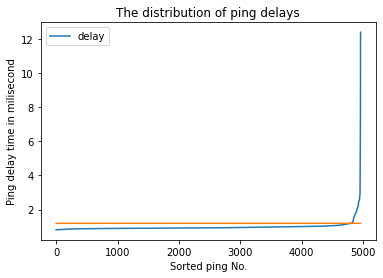

In [5]:
# Ping info
print("(*) Debug: The number of ping signals is " + str(len(ping_times)) + "\n")
print("(*) Debug: The average ping delay is " + str(round(sum(ping_delays) / len(ping_delays), 3)) + "\n")
print("(*) Debug: The ping delay distribution of adversary\n")

plt.plot(sorted(ping_delays), label="delay")
plt.plot([max_delay_time for x in range(len(ping_times))])
plt.title("The distribution of ping delays")
plt.xlabel("Sorted ping No.")
plt.ylabel("Ping delay time in milisecond")
plt.legend()
plt.show()

(*) Debug: The high delay ping distribution of adversary



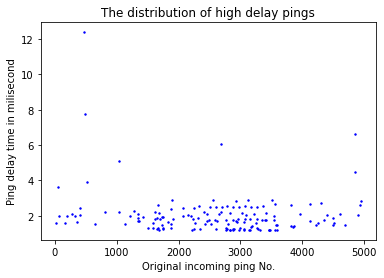

In [6]:
# Figure out the high pings
high_delay_pings = []
for count, ping in enumerate(ping_delays):
    if ping > max_delay_time:
        high_delay_pings.append([count, ping_delays[count]])

if len(high_delay_pings) > 0:
    high_delay_pings = np.array(high_delay_pings)
    print("(*) Debug: The high delay ping distribution of adversary\n")
    plt.scatter(high_delay_pings[:,0], high_delay_pings[:,1], s=2, c='blue')
    plt.title("The distribution of high delay pings")
    plt.xlabel("Original incoming ping No.")
    plt.ylabel("Ping delay time in milisecond")
    plt.show()
else:
    print("(*) Debug: There is no high delay pings under current criterion, try to make max_delay_time variable smaller")

In [7]:
# Group packets by window
get_key = lambda x: int(multiplier * float(x["frame.time_epoch"][0]))
# Sort packets
victim_packets = sorted(victim_packets, key=get_key)

times = []
sizes = []
incomings = []
intervals = {}

for k, g in groupby(victim_packets, get_key):
    cur_interval = {"interval": k, "packets": list(g)}
    cur_interval["size"] = sum(map(lambda x: int(x["frame.len"][0]), cur_interval["packets"]))
    cur_interval["incoming"] = sum(map(lambda x: int(x["frame.len"][0]), filter(lambda x: (x.get("ip.dst") and x["ip.dst"][0] == IP) or (x.get("ipv6.dst") and x["ipv6.dst"][0] == IPV6), cur_interval["packets"])))
    intervals[k] = cur_interval
    
    # fill in empty intervals
    while(times and k - (times[-1] * multiplier) > 1):
        times.append(times[-1] + (1.0 / multiplier))
        sizes.append(0)
        incomings.append(0)
    
    times.append(k / float(multiplier))
    sizes.append(cur_interval["size"])
    incomings.append(cur_interval["incoming"])

In [8]:
# Plotting
# Shift timestamps to start at 0
start_time = min(times)
new_times = [time - start_time for time in times]
new_ping_times = [time - start_time for time in ping_times]

(*) Debug: The time serial distribution of victim packet sizes



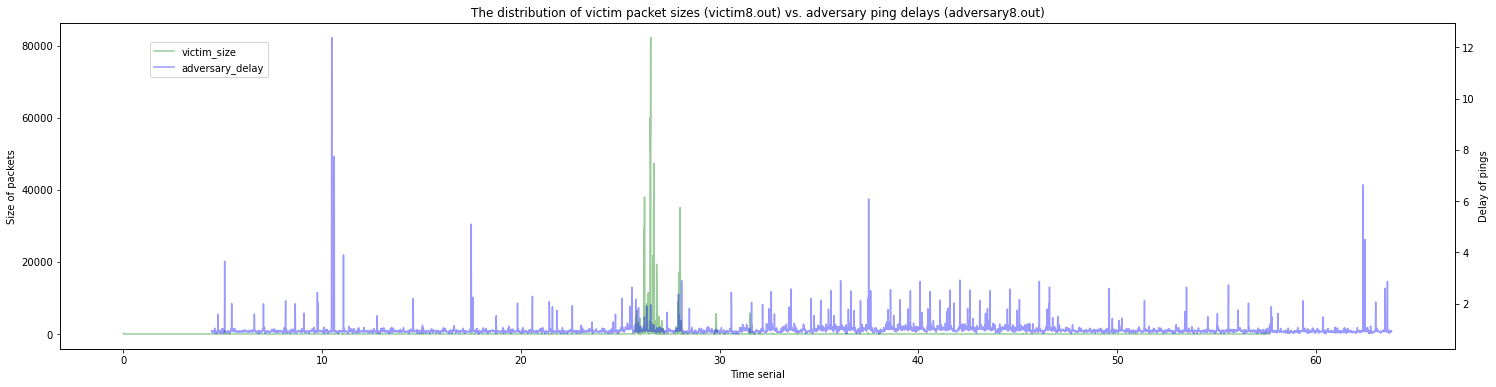

In [9]:
print("(*) Debug: The time serial distribution of victim packet sizes\n")
fig, ax1 = plt.subplots(figsize=(25,6))
ax2 = ax1.twinx()
ax1.plot(new_times, sizes, label="victim_size", color='green', alpha=0.4)
ax2.plot(new_ping_times, ping_delays, label="adversary_delay", color='blue', alpha=0.4)
ax1.set_title("The distribution of victim packet sizes (" + victim_name + ") vs. adversary ping delays (" + adversary_name + ")")
ax1.set_xlabel("Time serial")
ax1.set_ylabel("Size of packets")
ax2.set_ylabel("Delay of pings")
fig.legend(loc=(0.1,0.8))
fig.show()

In [10]:
# Victim packet analysis, in all period
ip_packet = {}
ip_packet['src'] = []
ip_packet['size'] = []
ip_packet['protocol'] = []
for packet in victim_packets:
    if 'ip.src' in packet:
        ip_src = packet['ip.src'][0]
        frame_len = float(packet['frame.len'][0])
        protocol = packet['frame.protocols'][0]
        ip_packet['src'].append(ip_src)
        ip_packet['size'].append(frame_len)
        ip_packet['protocol'].append(protocol)


In [11]:
packet_df = pd.DataFrame(ip_packet)
aver_size_df = packet_df.groupby(by = ['src', 'protocol']).mean().sort_values(by = 'size', ascending = False).reset_index().rename(columns={'size': 'average_size'}).round(1)
count_size_df = packet_df.groupby(by = ['src', 'protocol']).count().reset_index().rename(columns={'size': 'counts'})
packet_df1 = aver_size_df.merge(count_size_df, on = ['src', 'protocol'])
print("(*) Debug: The sources producing largest average packet sizes\n")
top_packet_df1 = packet_df1.iloc[:min(display_top_count, packet_df1.shape[0]),:]
top_packet_df1

(*) Debug: The sources producing largest average packet sizes



,src,protocol,average_size,counts
0,52.13.70.243,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,2036.0,1
1,99.84.222.92,eth:ethertype:ip:tcp:tls,1358.5,2
2,99.84.222.37,eth:ethertype:ip:tcp:tls,1336.1,9
3,99.84.222.92,eth:ethertype:ip:tcp:tls:tls,1149.0,1
4,99.84.222.37,eth:ethertype:ip:tcp:tls:tls,1117.0,3
5,72.21.91.29,eth:ethertype:ip:tcp:http:ocsp:ocsp,847.3,9
6,52.48.84.254,eth:ethertype:ip:tcp:tls,590.2,4
7,52.43.41.214,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,571.0,1
8,52.48.84.254,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,562.0,1
9,172.217.9.194,eth:ethertype:ip:tcp:tls,521.0,10


In [12]:
count_size_df = count_size_df.sort_values(by = 'counts', ascending = False)
packet_df2 = count_size_df.merge(aver_size_df, on= ['src', 'protocol'])
print("(*) Debug: The sources producing most packet counts\n")
top_packet_df2 = packet_df2.iloc[:min(display_top_count, packet_df2.shape[0]),:]
top_packet_df2

(*) Debug: The sources producing most packet counts



,src,protocol,counts,average_size
0,192.168.0.31,eth:ethertype:ip:tcp,123,65.4
1,192.168.0.31,eth:ethertype:ip:tcp:tls,41,290.1
2,75.75.75.75,eth:ethertype:ip:udp:dns,27,172.3
3,192.168.0.31,eth:ethertype:ip:udp:dns,27,95.3
4,99.84.222.37,eth:ethertype:ip:tcp,26,402.5
5,72.21.91.29,eth:ethertype:ip:tcp,15,68.7
6,52.13.70.243,eth:ethertype:ip:tcp,11,105.5
7,172.217.9.194,eth:ethertype:ip:tcp:tls,10,521.0
8,172.217.9.194,eth:ethertype:ip:tcp,10,69.2
9,99.84.222.37,eth:ethertype:ip:tcp:tls,9,1336.1


In [13]:
# Intersection of high volume and high frequency sources
intersect_df1 = top_packet_df1.merge(top_packet_df2, on=['src', 'protocol'])
print("(*) Debug: The intersection between two top lists\n")
intersect_df1.iloc[:,:4].rename(columns={'average_size_x': 'average_size', 'counts_x': 'counts'})

(*) Debug: The intersection between two top lists



,src,protocol,average_size,counts
0,99.84.222.37,eth:ethertype:ip:tcp:tls,1336.1,9
1,172.217.9.194,eth:ethertype:ip:tcp:tls,521.0,10


Busy traffic analysis is applying on  8, 9, 10, 11 since other adversary/victim pairs are irrelevant 

In [14]:
# Busy traffic analysis
# Measured by victim traffic packet sizes

busy_times = []
busy_ping_times = []
busy_sizes = []
busy_delays = []

if input_num == 8:
    for time, size in zip(new_times, sizes):
        if (time >= 25) and (time <= 30):
            busy_times.append(time)
            busy_sizes.append(size)
    
    for time, delay in zip(new_ping_times, ping_delays):
        if (time >= 25) and (time <= 30):
            busy_ping_times.append(time)
            busy_delays.append(delay)
elif input_num == 9:
    for time, size in zip(new_times, sizes):
        if (time >= 9.5) and (time <= 14.5):
            busy_times.append(time)
            busy_sizes.append(size)
    
    for time, delay in zip(new_ping_times, ping_delays):
        if (time >= 9.5) and (time <= 14.5):
            busy_ping_times.append(time)
            busy_delays.append(delay)
elif input_num == 10:
    for time, size in zip(new_times, sizes):
        if (time >= 16.5) and (time <= 20.5):
            busy_times.append(time)
            busy_sizes.append(size)
    
    for time, delay in zip(new_ping_times, ping_delays):
        if (time >= 16.5) and (time <= 20.5):
            busy_ping_times.append(time)
            busy_delays.append(delay)
elif input_num == 11:
    for time, size in zip(new_times, sizes):
        if ((time >= 8) and (time <= 10.5)) or ((time >= 19.5) and (time <= 21)) or ((time >= 30.5) and (time <= 31.5)) or ((time >= 41) and (time <= 42.5)) or ((time >= 56) and (time <= 57)):
            busy_times.append(time)
            busy_sizes.append(size)
    
    for time, delay in zip(new_ping_times, ping_delays):
        if ((time >= 8) and (time <= 10.5)) or ((time >= 19.5) and (time <= 21)) or ((time >= 30.5) and (time <= 31.5)) or ((time >= 41) and (time <= 42.5)) or ((time >= 56) and (time <= 57)):
            busy_ping_times.append(time)
            busy_delays.append(delay)

(*) Debug: The time serial distribution of busy traffic



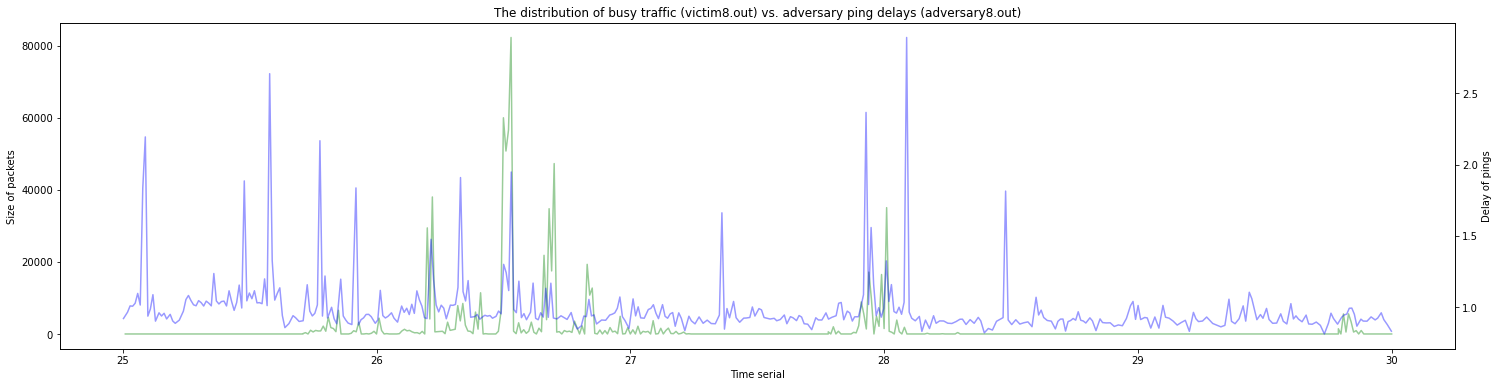

In [15]:
print("(*) Debug: The time serial distribution of busy traffic\n")
fig, ax1 = plt.subplots(figsize=(25,6))
ax2 = ax1.twinx()
ax1.plot(busy_times, busy_sizes, label="victim_size", color='green', alpha=0.4)
ax2.plot(busy_ping_times, busy_delays, label="adversary_delay", color='blue', alpha=0.4)
ax1.set_title("The distribution of busy traffic (" + victim_name + ") vs. adversary ping delays (" + adversary_name + ")")
ax1.set_xlabel("Time serial")
ax1.set_ylabel("Size of packets")
ax2.set_ylabel("Delay of pings")
# fig.legend(loc=(0.1,0.8))
fig.show()

In [16]:
# Victim packet analysis, in busy period
busy_ip_packet = {}
busy_ip_packet['src'] = []
busy_ip_packet['size'] = []
busy_ip_packet['protocol'] = []

if input_num == 8:
    busy_victim_packets = [x for x in victim_packets if (float(x['frame.time_epoch'][0]) - start_time > 25) and (float(x['frame.time_epoch'][0]) - start_time < 30)]
elif input_num == 9:
    busy_victim_packets = [x for x in victim_packets if (float(x['frame.time_epoch'][0]) - start_time > 9.5) and (float(x['frame.time_epoch'][0]) - start_time < 14.5)]
elif input_num == 10:
    busy_victim_packets = [x for x in victim_packets if (float(x['frame.time_epoch'][0]) - start_time > 16.5) and (float(x['frame.time_epoch'][0]) - start_time < 20.5)]
elif input_num == 11:
    busy_victim_packets = [x for x in victim_packets if ((float(x['frame.time_epoch'][0]) - start_time > 8) and (float(x['frame.time_epoch'][0]) - start_time < 10.5)) or ((float(x['frame.time_epoch'][0]) - start_time > 19.5) and (float(x['frame.time_epoch'][0]) - start_time < 21)) or ((float(x['frame.time_epoch'][0]) - start_time > 30.5) and (float(x['frame.time_epoch'][0]) - start_time < 31.5)) or ((float(x['frame.time_epoch'][0]) - start_time > 41) and (float(x['frame.time_epoch'][0]) - start_time < 42.5)) or ((float(x['frame.time_epoch'][0]) - start_time > 56) and (float(x['frame.time_epoch'][0]) - start_time < 57))]

for packet in busy_victim_packets:
    if 'ip.src' in packet:
        ip_src = packet['ip.src'][0]
        frame_len = float(packet['frame.len'][0])
        protocol = packet['frame.protocols'][0]
        busy_ip_packet['src'].append(ip_src)
        busy_ip_packet['size'].append(frame_len)
        busy_ip_packet['protocol'].append(protocol)

In [17]:
busy_packet_df = pd.DataFrame(busy_ip_packet)
busy_aver_size_df = busy_packet_df.groupby(by = ['src', 'protocol']).mean().sort_values(by = 'size', ascending = False).reset_index().rename(columns={'size': 'average_size'}).round(1)
busy_count_size_df = busy_packet_df.groupby(by = ['src', 'protocol']).count().reset_index().rename(columns={'size': 'counts'})
busy_packet_df1 = busy_aver_size_df.merge(busy_count_size_df, on = ['src', 'protocol'])
print("(*) Debug: The sources producing largest average packet sizes in busy period\n")
top_busy_packet_df1 = busy_packet_df1.iloc[:min(display_top_count, busy_packet_df1.shape[0]),:]
top_busy_packet_df1

(*) Debug: The sources producing largest average packet sizes in busy period



,src,protocol,average_size,counts
0,52.13.70.243,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,2036.0,1
1,99.84.222.92,eth:ethertype:ip:tcp:tls,1358.5,2
2,99.84.222.37,eth:ethertype:ip:tcp:tls,1336.1,9
3,99.84.222.92,eth:ethertype:ip:tcp:tls:tls,1149.0,1
4,99.84.222.37,eth:ethertype:ip:tcp:tls:tls,1117.0,3
5,72.21.91.29,eth:ethertype:ip:tcp:http:ocsp:ocsp,847.3,9
6,52.48.84.254,eth:ethertype:ip:tcp:tls,754.7,3
7,52.43.41.214,eth:ethertype:ip:tcp:tls,655.7,3
8,99.84.222.37,eth:ethertype:ip:tcp,578.5,17
9,52.43.41.214,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,571.0,1


In [18]:
print("(*) Debug: The intersection of ip sources producing largest traffic, between busy period and all period\n")
busy_intersect_df1 = top_packet_df1.merge(top_busy_packet_df1, on=['src', 'protocol']).iloc[:,:4].rename(columns={'average_size_x': 'average_size', 'counts_x': 'counts'})
print("(*) Debug: The number of intersected ip sources is " + str(busy_intersect_df1.shape[0]) + "\n")
print("(*) Debug: " + str(round(busy_intersect_df1.shape[0]/float(min(display_top_count, busy_packet_df1.shape[0]))*100, 1)) + "% of the ip sources are found in busy period" )
busy_intersect_df1

(*) Debug: The intersection of ip sources producing largest traffic, between busy period and all period

(*) Debug: The number of intersected ip sources is 8

(*) Debug: 80.0% of the ip sources are found in busy period


,src,protocol,average_size,counts
0,52.13.70.243,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,2036.0,1
1,99.84.222.92,eth:ethertype:ip:tcp:tls,1358.5,2
2,99.84.222.37,eth:ethertype:ip:tcp:tls,1336.1,9
3,99.84.222.92,eth:ethertype:ip:tcp:tls:tls,1149.0,1
4,99.84.222.37,eth:ethertype:ip:tcp:tls:tls,1117.0,3
5,72.21.91.29,eth:ethertype:ip:tcp:http:ocsp:ocsp,847.3,9
6,52.48.84.254,eth:ethertype:ip:tcp:tls,590.2,4
7,52.43.41.214,eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509s...,571.0,1


In [19]:
busy_count_size_df = busy_count_size_df.sort_values(by = 'counts', ascending = False)
busy_packet_df2 = busy_count_size_df.merge(busy_aver_size_df, on= ['src', 'protocol'])
print("(*) Debug: The sources producing most packet counts in busy period\n")
top_busy_packet_df2 = busy_packet_df2.iloc[:min(display_top_count, busy_packet_df2.shape[0]),:]
top_busy_packet_df2

(*) Debug: The sources producing most packet counts in busy period



,src,protocol,counts,average_size
0,192.168.0.31,eth:ethertype:ip:tcp,83,67.3
1,192.168.0.31,eth:ethertype:ip:tcp:tls,31,353.1
2,192.168.0.31,eth:ethertype:ip:udp:dns,27,95.3
3,75.75.75.75,eth:ethertype:ip:udp:dns,27,172.3
4,99.84.222.37,eth:ethertype:ip:tcp,17,578.5
5,172.217.9.194,eth:ethertype:ip:tcp:tls,10,521.0
6,72.21.91.29,eth:ethertype:ip:tcp,10,70.0
7,192.168.0.31,eth:ethertype:ip:tcp:http:ocsp,9,445.0
8,99.84.222.37,eth:ethertype:ip:tcp:tls,9,1336.1
9,72.21.91.29,eth:ethertype:ip:tcp:http:ocsp:ocsp,9,847.3


In [20]:
print("(*) Debug: The intersection of ip sources producing most packets, between busy period and all period\n")
busy_intersect_df2 = top_packet_df2.merge(top_busy_packet_df2, on=['src', 'protocol']).iloc[:,:4].rename(columns={'average_size_x': 'average_size', 'counts_x': 'counts'})
print("(*) Debug: The number of intersected ip sources is " + str(busy_intersect_df2.shape[0]) + "\n")
print("(*) Debug: " + str(round(busy_intersect_df2.shape[0]/float(min(display_top_count, busy_packet_df2.shape[0]))*100, 1)) + "% of the ip sources are found in busy period" )
busy_intersect_df2

(*) Debug: The intersection of ip sources producing most packets, between busy period and all period

(*) Debug: The number of intersected ip sources is 8

(*) Debug: 80.0% of the ip sources are found in busy period


,src,protocol,counts,average_size
0,192.168.0.31,eth:ethertype:ip:tcp,123,65.4
1,192.168.0.31,eth:ethertype:ip:tcp:tls,41,290.1
2,75.75.75.75,eth:ethertype:ip:udp:dns,27,172.3
3,192.168.0.31,eth:ethertype:ip:udp:dns,27,95.3
4,99.84.222.37,eth:ethertype:ip:tcp,26,402.5
5,72.21.91.29,eth:ethertype:ip:tcp,15,68.7
6,172.217.9.194,eth:ethertype:ip:tcp:tls,10,521.0
7,99.84.222.37,eth:ethertype:ip:tcp:tls,9,1336.1
